In [115]:
import numpy as np
import cv2
from PIL import Image

In [116]:
from cv2 import GaussianBlur
from math import sqrt
def get_octaves(img, sigma):
    """
    Get octaves of the image
    :param img: input image
    :param sigma: initial sigma
    """
    octaves = []
    filterSize = (5,5)
    g1 = GaussianBlur(img, filterSize, sigma)
    g2 = GaussianBlur(img, filterSize, sigma*sqrt(2))
    g3 = GaussianBlur(img, filterSize, sigma*2)
    g4 = GaussianBlur(img, filterSize, sigma*2*sqrt(2))
    g5 = GaussianBlur(img, filterSize, sigma*2*2)

    dog1 = g2 - g1
    dog2 = g3 - g2
    dog3 = g4 - g3
    dog4 = g5 - g4

    octaves = [dog1, dog2, dog3, dog4]
    return octaves


In [117]:
from PIL import Image
img = Image.open('notre_dame.jpg').convert('L')
img = img.resize((512, 512))
img = np.array(img)

octaves = get_octaves(img, sqrt(2))

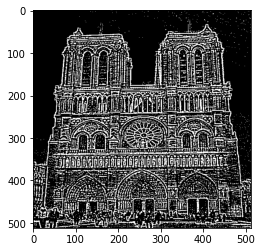

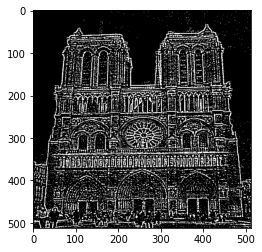

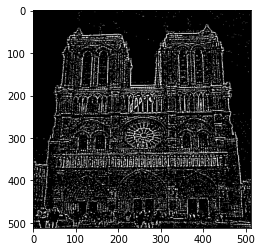

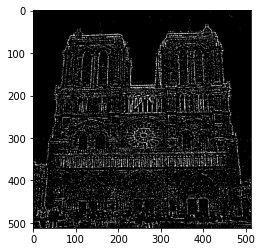

In [118]:
import matplotlib.pyplot as plt
for octave in octaves:
    plt.figure(); plt.imshow(octave, cmap='gray')

plt.show()

In [119]:
def generateScaleSpace(imgPath: str):
    """
    Generate scale space of the image
    :param imgPath: input image path
    """
    img = Image.open(imgPath).convert('L')
    img = img.resize((512, 512))
    img = np.array(img)
    pyramid = [img]
    sigmas = [sqrt(2)]
    scaleSpace = []
    for i in range(len(pyramid)):
        scaleSpace.append(get_octaves(pyramid[i], sigmas[i]))
    
    return scaleSpace

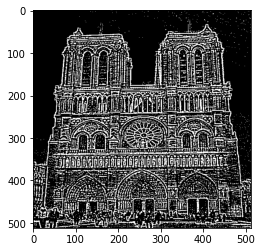

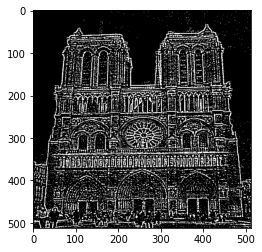

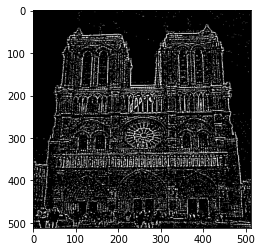

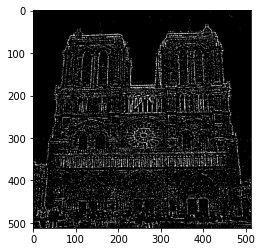

In [120]:
scaleSpace = generateScaleSpace('notre_dame.jpg')
for space in scaleSpace:
    for octave in space:
        plt.figure(); plt.imshow(octave, cmap='gray')

In [121]:
def getNeighbours(octaves, idx, i,j):
    """
    Returns the neighbours of the given pixel
    :param octaves: octaves of the image
    :param idx: octave index
    :param i: row index
    :param j: column index

    :return: neighbours of the given pixel
    """
    neighbours = []
    DIRS = [[1,0],[-1,0],[0,1],[0,-1],[-1,-1],[1,1],[-1,1],[1,-1]]
    for dx, dy in DIRS:
        x = i + dx
        y = j + dy
        if x >= 0 and x < octaves[idx].shape[0] and y >= 0 and y < octaves[idx].shape[1]:
            neighbours.append(octaves[idx][x,y])
    
    if(idx > 0):
        neighbours.append(octaves[idx-1][i,j])
        for dx, dy in DIRS:
            x = i + dx
            y = j + dy
            if x >= 0 and x < octaves[idx-1].shape[0] and y >= 0 and y < octaves[idx-1].shape[1]:
                neighbours.append(octaves[idx-1][x,y])
    
    if(idx < 2):
        neighbours.append(octaves[idx+1][i,j])
        for dx, dy in DIRS:
            x = i + dx
            y = j + dy
            if x >= 0 and x < octaves[idx+1].shape[0] and y >= 0 and y < octaves[idx+1].shape[1]:
                neighbours.append(octaves[idx+1][x,y])
    # print("Length of neighbours: ", len(neighbours))
    return neighbours


In [122]:
def get_keypoints(octaves):
    """
    Returns the keypoints of the image
    :param octaves: octaves of the image

    :return: keypoints of the image
    """
    keypoints = []

    for octave in octaves[1:-1]:
        for i in range(octave.shape[0]):
            for j in range(octave.shape[1]):
                neighbours = getNeighbours(octaves, 1, i,j)
                if(octave[i,j] > max(neighbours)):
                    keypoints.append((i,j))
                if(octave[i,j] < min(neighbours)):
                    keypoints.append((i,j))
    return keypoints


In [123]:
from random import randint
def visualize_keypoints(keypoints, imgPath: str):
    """
    Visualize the keypoints on the image
    :param keypoints: keypoints of the image
    :param img: input image
    """
    plt.figure()
    newImg = np.array(Image.open(imgPath).resize((512, 512)))
    for i,j in keypoints:
        borderColor = (57, 255, 20)
        randomColor = (randint(0,255), randint(0,255), randint(0,255))
        newImg = cv2.circle(newImg, (i, j), 4, randomColor, -1, cv2.LINE_AA)
        newImg = cv2.circle(newImg, (i, j), 4, borderColor, 1, cv2.LINE_AA)
    
    plt.imshow(newImg)

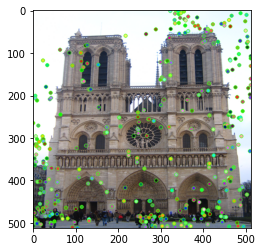

In [124]:
interestPoints = []
for octave in scaleSpace:
    interestPoints += (get_keypoints(octave))

visualize_keypoints(interestPoints, 'notre_dame.jpg')

### Add harris corners to remove outlier sifts

In [125]:
def im2single(im):
    im = im.astype(np.float32) / 255
    return im

def load_image(path):
    return im2single(cv2.imread(path))[:, :, ::-1]

In [126]:
def find_harris_corners(input_img_path, k = 0.04, window_size=16, threshold=10000):
    """
    Finds Harris corners in the image
    :param input_img_path: input image path
    :param k: Harris parameter
    :param window_size: window size
    :param threshold: threshold

    :return: Harris corners of the image
    """
    input_img = np.array(Image.open(input_img_path).convert('L').resize((512, 512)))
    
    corner_list = []
    
    offset = int(window_size/2)
    y_range = input_img.shape[0] - offset
    x_range = input_img.shape[1] - offset
    
    
    dy, dx = np.gradient(input_img)
    Ixx = dx**2
    Ixy = dy*dx
    Iyy = dy**2
    
    
    for y in range(offset, y_range):
        for x in range(offset, x_range):
            
            start_y = y - offset
            end_y = y + offset + 1
            start_x = x - offset
            end_x = x + offset + 1
            
            windowIxx = Ixx[start_y : end_y, start_x : end_x]
            windowIxy = Ixy[start_y : end_y, start_x : end_x]
            windowIyy = Iyy[start_y : end_y, start_x : end_x]
            
            
            Sxx = windowIxx.sum()
            Sxy = windowIxy.sum()
            Syy = windowIyy.sum()

            
            det = (Sxx * Syy) - (Sxy**2)
            trace = Sxx + Syy
            
            r = det - k*(trace**2)

            if r > threshold:
                corner_list.append([x, y, r])
        
    corner_list.sort(key=lambda x: x[2], reverse=True)

    return corner_list

In [127]:
corners = find_harris_corners('notre_dame.jpg')
corners = [(x,y) for x,y,_ in corners]

In [128]:
# add only those interest points that are also corners
finalPoints = []
for keypoint in interestPoints:
    if(keypoint in corners):
        finalPoints.append(keypoint)

    

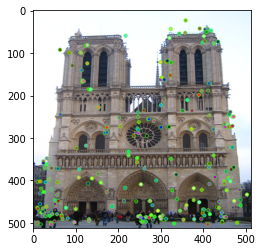

In [129]:
visualize_keypoints(finalPoints, 'notre_dame.jpg')

In [150]:
from math import sqrt, pi
import cv2
import numpy as np
def get_features(image_path, x, y):
  """
  Returns the features of the image at the given point
  :param image_path: input image path
  :param x: x coordinates of the points
  :param y: y coordinates of the points

  :return: features of the image at the given point
  """  
  # convert to numpy array
  image = load_image(image_path)
  image = cv2.resize(image, (512, 512))
  image= cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  
  x = np.array(x)
  x.astype(int)

  y = np.array(y)
  y.astype(int)

  #Define a gaussian filter.
  cutoff_frequency = 10
  filter1 = cv2.getGaussianKernel(ksize=4,sigma=cutoff_frequency)
  filter1 = np.dot(filter1, filter1.T)
  image = cv2.filter2D(image, -1, filter1)
  
  lenX = len(x)
  
  FeatureVectorIn = np.ones((lenX,128))
  NormalizedFeature = np.zeros((lenX,128))

  #loop over the interet points 
  for i in range(lenX):
    #Extract a 16X16 window centered at the corner pixel
    xCorr = x[i]
    yCorr = y[i]
    Window = image[yCorr-8:yCorr + 8, xCorr-8:xCorr + 8]
    for p in range(4):
      for q in range(4):
        # print(p,q)
        # Divide into 4x4 bins for each Window
        WindowCut = Window[p*4:p*4 +4,q*4: q*4+4]
        if(WindowCut.shape != (4,4)):
          continue
        # print(WindowCut.shape)
        NewWindowCut = cv2.copyMakeBorder(WindowCut, 1, 1, 1, 1, cv2.BORDER_REFLECT)
        # print("new window cut")
        Magnitude = np.zeros((4,4))
        Orientation = np.zeros((4,4))
        
        # get magnitude and orientation for each 4x4 window
        for r in range(WindowCut.shape[0]):
          for s in range(WindowCut.shape[1]):
            Magnitude[r,s] = sqrt((NewWindowCut[r+1,s] - NewWindowCut[r-1,s])**2 + (NewWindowCut[r,s+1] - NewWindowCut[r,s-1])**2)
            Orientation[r,s] = np.arctan2((NewWindowCut[r+1,s] - NewWindowCut[r-1,s]),(NewWindowCut[r,s+1] - NewWindowCut[r,s-1]))

        # convert into radians
        OrientationNew = Orientation*(180/(pi))
        # make histogram with wts as magnitude
        hist, _ = np.histogram(OrientationNew, bins = 8, range = (-180,180), weights = Magnitude)

        # fill in the fearture vector
        for t in range(8):
          l = t+p*32+q*8
          FeatureVectorIn[i,l] = hist[t]

  denominator = np.sqrt(np.sum(np.square(FeatureVectorIn), axis = 1))
  for a in range(FeatureVectorIn.shape[0]):
    if(denominator[a] == 0):
      continue
    NormalizedFeature[a] = FeatureVectorIn[a]/denominator[a]

  fv = NormalizedFeature

  return fv

In [151]:
xCorr = [p[0] for p in finalPoints]
yCorr = [p[1] for p in finalPoints]
featureVector1 = get_features('notre_dame.jpg', xCorr, yCorr)

In [152]:
featureVector1

array([[0.        , 0.07129957, 0.22601017, ..., 0.00614788, 0.01772653,
        0.        ],
       [0.14169474, 0.        , 0.        , ..., 0.03844825, 0.11092174,
        0.        ],
       [0.01150699, 0.06251536, 0.01938239, ..., 0.60789136, 0.18129575,
        0.0212364 ],
       ...,
       [0.03275183, 0.01092937, 0.        , ..., 0.        , 0.        ,
        0.41279173],
       [0.04183753, 0.00417247, 0.00587437, ..., 0.09942129, 0.        ,
        0.03291277],
       [0.35091106, 0.08194611, 0.        , ..., 0.03277578, 0.00375525,
        0.14265387]])

In [153]:
def match_features(features1, features2):
    """
    Returns the matches between two sets of features.
    :param features1: Features of the first image
    :param features2: Features of the second image

    :return: A list of tuples representing the matches
    """
    Distance = np.zeros(shape = (features1.shape[0], features2.shape[0]))
    
    diffs = []
    f1Match = []
    f2Match = []
    for i in range(features1.shape[0]):
        # find closest match for feature i
        for j in range(features2.shape[0]):

            featureRow1 = features1[[i],:]
            featureRow2 = features2[[j],:]
           
            difference = np.subtract(featureRow1, featureRow2)
            diffSquare = np.square(difference)
            Distance[i][j] = np.sqrt(np.sum(diffSquare))

        IndexPosition = np.argsort(Distance[i,:])
        
        d1 = IndexPosition[0] #closest feature
        d2 = IndexPosition[1] #second closest feature   

        diff1 = float(Distance[i,d1])
        diff2 = float(Distance[i,d2])
        try:
            ratio = diff1/diff2
        except:
            ratio = 1
        
        if ratio<0.8:
            f1Match.append(i)
            f2Match.append(d1)
            diffs.append(diff1)

    f1Match = np.asarray(f1Match)
    f2Match = np.asarray(f2Match)
    matches = np.stack((f1Match,f2Match), axis = -1)
    diffs = np.asarray(diffs)

    return matches, diffs

In [154]:
def getFeatureVector(imgPath, verbose = False):
    """
        Extracts the feature vector from the image.
        Steps:
            1. Load the image
            2. Convert the image to grayscale
            3. Find the interest points
            4. Extract the feature vector
    """
    # generate scale space
    scaleSpace = generateScaleSpace(imgPath)
    # find interest points with maxima or minima 26 pts 
    interestPoints = []
    for octave in scaleSpace:
        interestPoints += (get_keypoints(octave))
    
    # find corners in the img
    corners = find_harris_corners(imgPath)
    corners = [(x,y) for x,y,_ in corners]
    
    # find the interest points that are corners
    finalPoints = []
    for keypoint in interestPoints:
        if(keypoint in corners):
            finalPoints.append(keypoint)
    
    if(verbose):
        visualize_keypoints(finalPoints, imgPath)
    
    # get the feature vector
    featureVector = get_features(imgPath, [p[0] for p in finalPoints], [p[1] for p in finalPoints])
    
    return featureVector
    



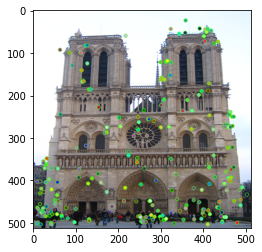

In [155]:
featureVector1 = getFeatureVector('notre_dame.jpg', verbose = True)

In [136]:
featureVector2 = getFeatureVector('images/Test Images/notre_dame2.jpg', verbose = False)

In [137]:
matches, diffs = match_features(featureVector1, featureVector2)
print("Total matches = ", len(matches))

Total matches =  10


In [138]:
import os
for test_image in os.listdir('images/Test Images'):
    test_image_path = 'images/Test Images/' + test_image
    test_feature_vector = getFeatureVector(test_image_path, verbose = False)
    matches, diffs = match_features(featureVector1, test_feature_vector)
    print("Total matches = ", len(matches), "with", test_image)

Total matches =  12 with Gateway_Test2.jfif
Total matches =  10 with notre_dame2.jpg
Total matches =  15 with India_Gate_Test1.jfif
Total matches =  13 with Gateway_Test1.jfif


## Using CV2 inbuilt to get more accurate key points

In [156]:
def generateCV2Kps(imagePath: str, jmp: int = 2, verbose = False):
    """
    Generates the keypoints using the OpenCV library.
    :param imagePath: Path to the image
    :param jmp: Jump size for the keypoints

    :return: A list of keypoints
    """
    img = cv2.imread(imagePath)
    img = cv2.resize(img, (512, 512))
    gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    kp = sift.detect(gray,None)
    kp = kp[::jmp]
    kpts = [x.pt for x in kp]
    kpts = [(int(x),int(y)) for x,y in kpts]

    if(verbose):
        visualize_keypoints(kpts, imagePath)
    
    return kpts

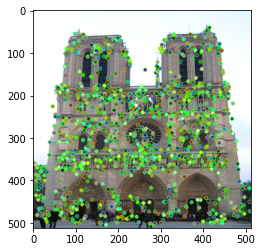

In [157]:
kpts = generateCV2Kps('notre_dame.jpg', 2, verbose = True)

In [158]:
def getFeatureVector_CV2KP(imgPath, verbose = False):
    """
        Extracts the feature vector from the image.
        :param imgPath: Path to the image
        :param verbose: If True, display the image with the interest points
        :return: The feature vector
    """
    # get the keypoints
    kpts = generateCV2Kps(imgPath, 2, verbose = verbose)
    print("Found",len(kpts), "key-points")
    
    # get the feature vector
    featureVector = get_features(imgPath, [p[0] for p in kpts], [p[1] for p in kpts])
    return featureVector

Found 1061 key-points


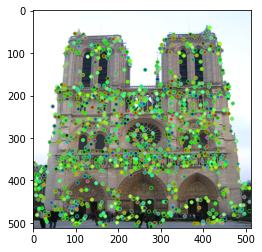

In [159]:
featureVector1 = getFeatureVector_CV2KP('notre_dame.jpg', verbose = True)

Found 853 key-points


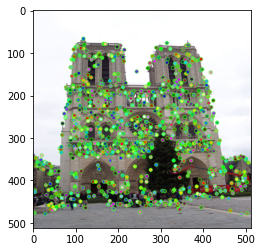

In [160]:
featureVector2 = getFeatureVector_CV2KP('images/Test Images/notre_dame2.jpg', verbose = True)

In [161]:
matches, diffs = match_features(featureVector1, featureVector2)
print("Total matches = ", len(matches))

Total matches =  71


Found 456 key-points
Total matches =  35 with Gateway_Test2.jfif
Found 853 key-points
Total matches =  71 with notre_dame2.jpg
Found 262 key-points
Total matches =  24 with India_Gate_Test1.jfif
Found 1350 key-points
Total matches =  20 with Gateway_Test1.jfif


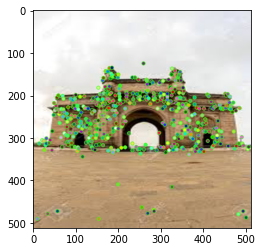

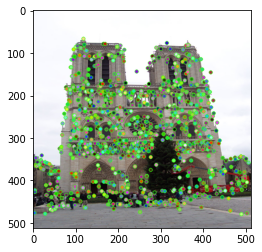

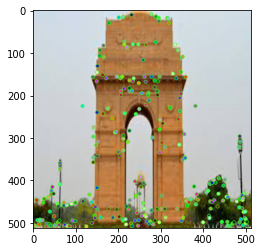

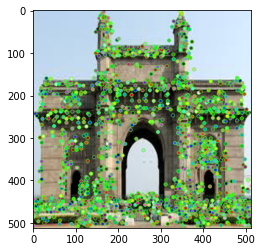

In [162]:
import os
for test_image in os.listdir('images/Test Images'):
    test_image_path = 'images/Test Images/' + test_image
    test_feature_vector = getFeatureVector_CV2KP(test_image_path, verbose = True)
    matches, diffs = match_features(featureVector1, test_feature_vector)
    print("Total matches = ", len(matches), "with", test_image)

### Make a training Data-Base

In [176]:
def genrateTrainingDb(dirPath: str):
    """
        Generate Training Database
        :param dirPath: Path to Training Database
        :return: A tuple of feature vectors and labels
    """
    db = []
    labels = {}
    for image in os.listdir(dirPath):
        imageName = image.split('.')[0]
        if(imageName[-1].isdigit()):
            imageName = imageName[:-1]
        if(imageName not in labels):
            labels[imageName] = len(labels)+1
        print("Processing image:", imageName)
        imgLabel = labels[imageName]
        imgPath = dirPath + '/' + image
        db.append([imgLabel,getFeatureVector_CV2KP(imgPath, verbose = False)])
    
    return db, labels
    

In [177]:
trainingDb, trainLabels = genrateTrainingDb('images/TrainImages')

Processing image: Sleeping_beauty
Found 810 key-points
Processing image: Gateway
Found 977 key-points
Processing image: Mount_Rushmore
Found 999 key-points
Processing image: Mount_Rushmore
Found 868 key-points
Processing image: Statue_of_liberty
Found 266 key-points
Processing image: Sacre_Coecur
Found 795 key-points
Processing image: Gateway
Found 630 key-points
Processing image: Statue_of_liberty
Found 520 key-points
Processing image: India_Gate
Found 500 key-points
Processing image: Notre_Dame
Found 853 key-points
Processing image: Pantheon_Paris
Found 677 key-points
Processing image: Notre_Dame
Found 1034 key-points
Processing image: OperaHouse
Found 511 key-points
Processing image: Episcopal_Gaudi
Found 1216 key-points
Processing image: India_Gate
Found 300 key-points
Processing image: India_Gate
Found 709 key-points
Processing image: Gateway
Found 993 key-points


In [178]:
print(trainLabels)

{'Sleeping_beauty': 1, 'Gateway': 2, 'Mount_Rushmore': 3, 'Statue_of_liberty': 4, 'Sacre_Coecur': 5, 'India_Gate': 6, 'Notre_Dame': 7, 'Pantheon_Paris': 8, 'OperaHouse': 9, 'Episcopal_Gaudi': 10}


In [180]:
"""
    Preparing the test data
"""
totalImgs = 0
correctImgs = 0
for test_image in os.listdir('images/Test Images'):
    test_image_path = 'images/Test Images/' + test_image
    testImgName = test_image.split('.')[0]
    actualLabel = trainLabels[testImgName]
    test_feature_vector = getFeatureVector_CV2KP(test_image_path, verbose = False)
    maxMatches = 0
    predictedLabel = None
    for label, featureVector in trainingDb:
        matches, diffs = match_features(test_feature_vector, featureVector)
        print("Matches = ", len(matches), "with", label)
        if(len(matches) > maxMatches):
            maxMatches = len(matches)
            predictedLabel = label
    print("Actual label", actualLabel, "Predicted label", predictedLabel)
    if(predictedLabel == actualLabel):
        correctImgs += 1
    totalImgs += 1
print("Accuracy", correctImgs/totalImgs)

Found 921 key-points
Matches =  22 with 1
Matches =  17 with 2
Matches =  15 with 3
Matches =  23 with 3
Matches =  38 with 4
Matches =  27 with 5
Matches =  12 with 2
Matches =  16 with 4
Matches =  17 with 6
Matches =  21 with 7
Matches =  24 with 8
Matches =  12 with 7
Matches =  21 with 9
Matches =  13 with 10
Matches =  25 with 6
Matches =  39 with 6
Matches =  17 with 2
Actual label 7 Predicted label 6
Found 262 key-points
Matches =  12 with 1
Matches =  10 with 2
Matches =  14 with 3
Matches =  7 with 3
Matches =  26 with 4
Matches =  13 with 5
Matches =  8 with 2
Matches =  19 with 4
Matches =  17 with 6
Matches =  10 with 7
Matches =  12 with 8
Matches =  7 with 7
Matches =  11 with 9
Matches =  11 with 10
Matches =  34 with 6
Matches =  14 with 6
Matches =  19 with 2
Actual label 6 Predicted label 6
Found 456 key-points
Matches =  14 with 1
Matches =  7 with 2
Matches =  11 with 3
Matches =  10 with 3
Matches =  21 with 4
Matches =  6 with 5
Matches =  23 with 2
Matches =  12

### Laplacian Of Gaussian/The Marr-Hildreth Edge Detector

In [192]:
def applyLoG(img, sigma=1, filterSize=7):   
    """
        Applies the LoG filter to the image
        :param img: The image
        :param sigma: The sigma value of the LoG filter
        :return: The LoG filtered image
    """
    size = filterSize

    x, y = np.meshgrid(np.arange(-size/2+1, size/2+1),
                       np.arange(-size/2+1, size/2+1))

    normal = 1 / (2.0 * np.pi * sigma**2)

    # G(x,y) = (x^2 + y^2 - 2sigma^2)/(sigma^4) * e^(-(x^2 + y^2)/(2sigma^2))

    kernel = ((x**2 + y**2 - (2.0*sigma**2)) / sigma**4) * \
        np.exp(-(x**2+y**2) / (2.0*sigma**2)) / normal  

    kern_size = kernel.shape[0]
    log = np.zeros_like(img, dtype=float)

    # convolving img with kernel
    for i in range(img.shape[0]-(kern_size-1)):
        for j in range(img.shape[1]-(kern_size-1)):
            window = img[i:i+kern_size, j:j+kern_size] * kernel
            log[i, j] = np.sum(window)

    return log.astype(np.int64, copy=False), kern_size
    

In [193]:
def computeZeroCrossing(img: np.array, tolerance: None):
    """
        Computes the zero crossing of the image
        :param img: The image
        :return: The zero crossing of the image
    """
    zeroCrossing = np.zeros_like(img, dtype=float)
    # computing zero crossing
    if(not tolerance):
        for i in range(1,img.shape[0]-1):
            for j in range(1,img.shape[1]-1):
                if img[i][j] == 0:
                    if (img[i][j-1] < 0 and img[i][j+1] > 0) or (img[i][j-1] < 0 and img[i][j+1] < 0) or (img[i-1][j] < 0 and img[i+1][j] > 0) or (img[i-1][j] > 0 and img[i+1][j] < 0):
                        zeroCrossing[i][j] = 255
                if img[i][j] < 0:
                    if (img[i][j-1] > 0) or (img[i][j+1] > 0) or (img[i-1][j] > 0) or (img[i+1][j] > 0):
                        zeroCrossing[i][j] = 255
    else:
        maxLog = np.amax(img)
        for i in range(1,img.shape[0]-1):
            for j in range(1,img.shape[1]-1):
                if img[i][j] == 0:
                    if (img[i][j-1] < 0 and img[i][j+1] > 0 and abs(img[i,j-1]-img[i,j+1]) > tolerance*maxLog) \
                        or (img[i][j-1] < 0 and img[i][j+1] < 0 and abs(img[i,j-1]- img[i,j+1]) > tolerance*maxLog) \
                        or (img[i-1][j] < 0 and img[i+1][j] > 0 and abs(img[i-1,j]- img[i+1,j])> tolerance*maxLog)\
                        or (img[i-1][j] > 0 and img[i+1][j] < 0 and abs(img[i-1,j]- img[i+1,j])> tolerance*maxLog):

                        zeroCrossing[i][j] = 255

                if img[i][j] < 0:
                    if (img[i][j-1] > 0 and abs(img[i,j-1]-img[i,j])> tolerance*maxLog)\
                    or (img[i][j+1] > 0 and abs(img[i,j+1]-img[i,j])> tolerance*maxLog)\
                    or (img[i-1][j] > 0 and abs(img[i-1,j]- img[i,j])> tolerance*maxLog)\
                    or (img[i+1][j] > 0 and abs(img[i+1,j]- img[i,j])> tolerance*maxLog):
                        
                        zeroCrossing[i][j] = 255
                        
    return zeroCrossing

In [194]:
def edgesMarrHildreth(img, sigma=1, tolerance=None):
    """
        finds the edges using MarrHildreth edge detection method...
        :param im : input image
        :param sigma : sigma is the std-deviation and refers to the spread of gaussian
        :return: a binary edge image
    """
    
    log, kern_size = applyLoG(img, sigma)
    zeroCrossing = computeZeroCrossing(log, tolerance)
    return log, zeroCrossing

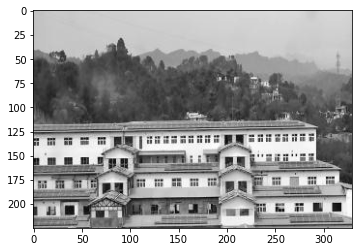

In [195]:
img = Image.open('north.jpg').convert('L')
img = np.array(img)
plt.imshow(img, cmap='gray')

In [196]:
log, zeroCrossing = edgesMarrHildreth(img, sigma=1)

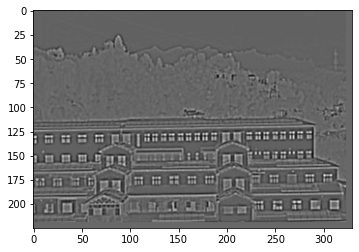

In [197]:
plt.imshow(log, cmap='gray')

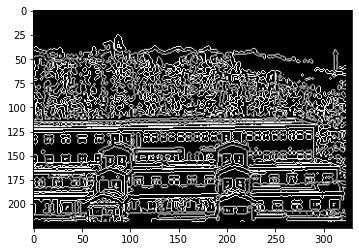

In [198]:
plt.imshow(zeroCrossing, cmap='gray')

#### adding 4percent threshold

In [199]:
log, zeroCrossing = edgesMarrHildreth(img, sigma=1, tolerance=0.04)

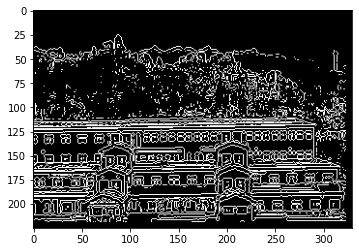

In [200]:
plt.imshow(zeroCrossing, cmap='gray')

#### Similarly on top view

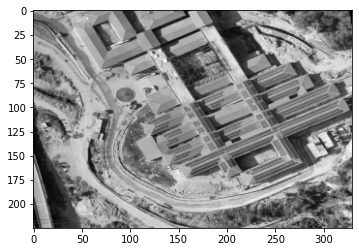

In [201]:
img = Image.open('top view.png').convert('L')
img = np.array(img)
plt.imshow(img, cmap='gray')

In [208]:
log, zeroCrossing = edgesMarrHildreth(img, sigma=1, tolerance=0.2)

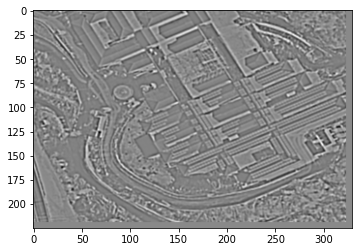

In [209]:
plt.imshow(log, cmap='gray')

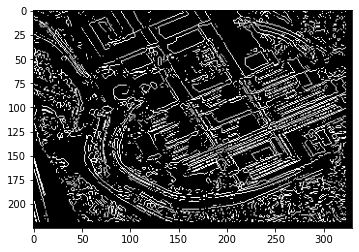

In [210]:
plt.imshow(zeroCrossing, cmap='gray')

## Hough Transform

In [266]:
def hough_line(img: np.array):
    """
        Detect lines using hough transform
        :param img: The image
        :return: The hough transform image
    """
    # Rho and Theta ranges
    thetas = np.deg2rad(np.arange(-90.0, 90.0))
    width, height = img.shape
    # maxRHO
    maxRho = int(np.ceil(np.sqrt(width * width + height * height)))
    rhos = np.linspace(-maxRho, maxRho, maxRho * 2)
    
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    # Hough accumulator array of theta vs rho
    accumulatorTable = np.zeros((2 * maxRho, num_thetas), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(img)  # (row, col) indexes to edges

    
    for i in range(len(x_idxs)):
      x = x_idxs[i]
      y = y_idxs[i]

      for t_idx in range(num_thetas):
        rho = round(x * cos_t[t_idx] + y * sin_t[t_idx]) + maxRho
        accumulatorTable[rho, t_idx] += 1

    return accumulatorTable, thetas, rhos

In [268]:
acc, thetas, rhos = hough_line(zeroCrossing)
accShape0,accShape1 = acc.shape
acc = acc.flatten()
accIdxs = np.argsort(acc)[::-1]
print(accIdxs)

[108877 108338 110858 ...  62949  62950      0]


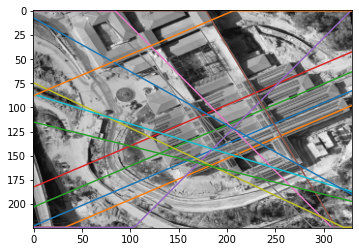

In [279]:
plottedIdxs = []
for i in range(100):
    notPlot = False
    for pltIdx in plottedIdxs:
        if abs(accIdxs[i]-pltIdx) < 2000:
            notPlot = True
            break
    
    if notPlot:
        continue
    theta = thetas[accIdxs[i]%accShape1]
    rho = rhos[accIdxs[i]//accShape1]

    x = np.linspace(0, img.shape[1] - 1, img.shape[1])
    y = ((rho - x * np.cos(theta)) / np.sin(theta)).clip(0,img.shape[0] - 1)
    plt.imshow(img, cmap='gray')
    plt.plot(x, y)
    plottedIdxs.append(accIdxs[i])

## Comparision with inbuilt openCV method

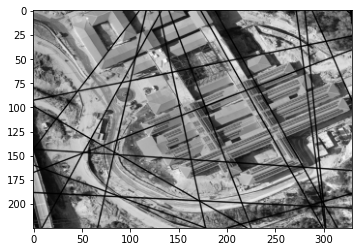

In [294]:
import math
src = cv2.imread('Top view.png', cv2.IMREAD_GRAYSCALE)
dst = cv2.Canny(src, 50, 200, None, 3)
orig = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)

lines = cv2.HoughLinesP(dst, 1, np.pi / 180, 140, None, 0, 0)
if lines is not None:
        for i in range(0, len(lines)):
            rho = lines[i][0][0]
            theta = lines[i][0][1]
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
            pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
            cv2.line(src, pt1, pt2, (0,255,255), 1, cv2.LINE_AA)

plt.imshow(src, cmap='gray')
plt.show()

In [470]:
def getAvgNeigbour(img: np.array, x: int, y: int) -> np.float32:
    """
        Returns the average sum of neighbours
        :param img: The image
        :param x: The x coordinate
        :param y: The y coordinate
        :return: The average sum of neighbours
    """
    avg = 0
    for i in range(x-1, x+2):
        for j in range(y-1, y+2):
            if i < 0 or j < 0 or i >= img.shape[0] or j >= img.shape[1]:
                continue
            avg += img[i][j]
    return np.float32(avg/9)
    

def HoughCircles(input,circles, threshold = 150, tolerance = 33): 
    """
        Detect circles using hough transform
        :param input: The image
        :param circles: An array to store the circles
        :param threshold: The threshold value
        :param tolerance: The tolerance value (avg value of neighbours)
    """
    rows = input.shape[0] 
    cols = input.shape[1] 
    
    # initializing the angles to be computed 
    sinang = dict() 
    cosang = dict() 
    
    # initializing the angles  
    for angle in range(0,360): 
        sinang[angle] = np.sin(angle * np.pi/180) 
        cosang[angle] = np.cos(angle * np.pi/180) 
            
    
    length=22
    radius = [i for i in range(14,length)]
    
    for r in radius:
        #Initializing an empty 2D array with zeroes 
        acc_cells = np.full((rows,cols),fill_value=0,dtype=np.uint64)
         
        # Iterating through the original image 
        for x in range(rows): 
            for y in range(cols): 
                if input[x][y] == 255:# edge 
                    # increment in the accumulator cells 
                    for angle in range(0,360): 
                        b = y - round(r * sinang[angle]) #y_center
                        a = x - round(r * cosang[angle]) #x_center
                        if a >= 0 and a < rows and b >= 0 and b < cols: 
                            acc_cells[a][b] += 1
                             
        print('For radius: ',r)
        acc_cell_max = np.amax(acc_cells)
        
        if(acc_cell_max > threshold):  
            acc_cells[acc_cells < threshold] = 0  
            for i in range(rows): 
                for j in range(cols): 
                    if(i > 0 and j > 0 and i < rows-1 and j < cols-1 and acc_cells[i][j] >= threshold):
                        avg_sum = getAvgNeigbour(acc_cells,i,j)
                        if(avg_sum >= tolerance):
                            print("For radius: ",r,"average: ",avg_sum,"\n")
                            circles.append((i,j,r))
                            acc_cells[i:i+5,j:j+7] = 0


In [471]:
circles = []
img = Image.open('coins.png').convert('L')
img = np.array(img)
log, zeroCrossing = edgesMarrHildreth(img, sigma=1, tolerance=0.1)
HoughCircles(zeroCrossing,circles, 150, 30)  


For radius:  14
For radius:  14 average:  38.333332 

For radius:  15
For radius:  15 average:  38.22222 

For radius:  16
For radius:  16 average:  45.11111 

For radius:  16 average:  45.444443 

For radius:  16 average:  58.555557 

For radius:  16 average:  54.333332 

For radius:  16 average:  43.333332 

For radius:  16 average:  44.22222 

For radius:  16 average:  48.11111 

For radius:  16 average:  43.88889 

For radius:  16 average:  44.555557 

For radius:  16 average:  35.555557 

For radius:  16 average:  36.77778 

For radius:  16 average:  41.555557 

For radius:  16 average:  43.11111 

For radius:  17
For radius:  17 average:  34.444443 

For radius:  17 average:  36.88889 

For radius:  17 average:  36.555557 

For radius:  17 average:  36.22222 

For radius:  17 average:  39.11111 

For radius:  17 average:  39.88889 

For radius:  17 average:  38.77778 

For radius:  18
For radius:  19
For radius:  20
For radius:  20 average:  39.22222 

For radius:  20 average:  3

In [472]:
circles

[(37, 218, 14),
 (38, 217, 15),
 (32, 147, 16),
 (50, 48, 16),
 (64, 174, 16),
 (77, 102, 16),
 (96, 163, 16),
 (104, 129, 16),
 (107, 88, 16),
 (110, 202, 16),
 (127, 174, 16),
 (136, 71, 16),
 (136, 103, 16),
 (142, 211, 16),
 (160, 182, 16),
 (65, 173, 17),
 (107, 87, 17),
 (110, 201, 17),
 (127, 173, 17),
 (137, 70, 17),
 (137, 102, 17),
 (143, 210, 17),
 (28, 184, 20),
 (35, 112, 20),
 (29, 183, 21),
 (36, 111, 21),
 (68, 137, 21),
 (73, 209, 21),
 (87, 56, 21),
 (126, 35, 21),
 (141, 139, 21)]

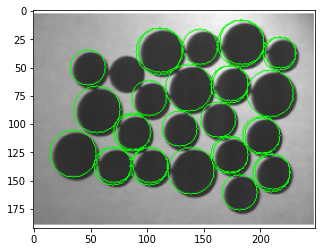

In [473]:
img = Image.open('coins.png')
img = np.array(img)

for vertex in circles:
    cv2.circle(img,(vertex[1],vertex[0]),vertex[2],(0,255,0),1)
        
plt.imshow(img)